In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
#import enchant
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## RegExp crash course

https://regex101.com

https://regexr.com

In [3]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [4]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [5]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [6]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [7]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [8]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [9]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [10]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [11]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [12]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [13]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [14]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

# Обработка реального текста

In [15]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [16]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

[**Data**](http://study.mokoron.com/)

---

In [17]:
# -*- coding: utf-8 -*-
import time
import xml.etree.cElementTree as ET
tree = ET.ElementTree(file="file1.xml")
root = tree.getroot()

In [19]:
catalog_1=root[0][0]

print(catalog_1[49].text)

Вице-премьер Алексей Гордеев дал поручение компетентным ведомствам совместно с научным сообществом составить список продуктов, которые надо будет в обязательном порядке обогатить витаминами и микроэлементами. Об этом сообщает РБК со ссылкой на пресс-службу чиновника.
Поручение было дано по итогам заседания межведомственной рабочей группы по реализации Стратегии повышения качества пищевой продукции в России до 2030 года. В частности, планируется сделать обязательным йодирование соли и обогащение молока витаминами A и D.
«Наша задача — обеспечить [людей] такими продуктами с необходимым содержанием витаминов и микроэлементов, поступающих на полки наших магазинов», — сообщил Гордеев.
Обязательное йодирование соли пытаются ввести уже давно. Подобный законопроект партия «Единая Россия» вносила в Госдуму еще в 2013 году. В пояснительной записке указывалось, что «добровольная модель» йодирования соли не оправдалась, при этом «с экономической точки зрения использование йодированной поваренной с

In [20]:
import csv
our_list=[]
for i in range(200):
    our_list.insert(i, ['data'])
file = open('__data.csv', 'w')
with file:
    ww=csv.writer(file)
    ww.writerows(our_list)
print("Done")

Done


In [21]:
DATA_PATH = '__data.csv'

In [22]:
df = pd.read_csv(DATA_PATH, header=None,
                 names=['ttext'])
print(df.shape)

(200, 1)


In [23]:
df.dtypes

ttext    object
dtype: object

In [24]:
catalog_1=root[0][0]
for i in range(50):
    df.ttext[i]=catalog_1[i].text
catalog_1=root[0][1]
for i in range(50,100):
    df.ttext[i]=catalog_1[i-50].text
catalog_1=root[0][2]
for i in range(100,150):
    df.ttext[i]=catalog_1[i-100].text
catalog_1=root[0][3]
for i in range(150,200):
    df.ttext[i]=catalog_1[i-150].text

In [25]:
df.ttext[50]=catalog_1[13].text

In [26]:
df.head(200)

ttext
0    Американские производители и владельцы оружия ...
1    Генпрокуратура начала проверку о размещении в ...
2    «Роснефть» начала испытания инновационного пол...
3    «Газпром» отказался от привлечения малых и сре...
4    Федеральной антимонопольной службе (ФАС) офици...
5    Аналитики Альфа-банка полагают, что российская...
6    Президент Украины Петр Порошенко похвастался э...
7    Реализация проекта газопровода «Северный поток...
8    «Ростелеком» готовится приобрести сотовый опер...
9    Британский автопроизводитель Jaguar Land Rover...
10   Неравенство доходов — актуальная проблема для ...
11   В 2018 году «Роснефть» увеличила розничную про...
12   Австралийское бюро статистики (ABS) выявило пр...
13   Глава социального комитета Совфеда Валерий Ряз...
14   Власти Венесуэлы вполне могут просрочить выпла...
15   Глава ВТБ Андрей Костин категорически опроверг...
16   Производители молочной продукции будут обязаны...
17   В России отмечается рост цен на отдельные това...
18   Крупнейший за последние годы алмаз был найден ...
19   Правительство сможет вносить изменения в крупн...
20   Большая часть 2018 года сопровождалась панихид...
21   В России увеличилось количество поддельных куп...
22   Российским нефтяным компаниям необходимо более...
23   «Почта России», которую возглавляет Николай По...
24   Техническое решение для пересечения «Северного...
25   Объемы нелегальных операций российских компани...
26   Общая выручка компании «Донстрой» по итогам 20...
27   Самыми популярными лекарствами в российских ап...
28   Жаловаться в соцсетях на отдельных людей или ц...
29   Авиакомпания «Россия» (входит в группу «Аэрофл...
..                                                 ...
170  Российские застройщики будут сокращать площади...
171  Российский Forbes составил рейтинг «Короли нед...
172  Россияне все чаще покупают жилье за рубежом. П...
173  Уже через год в Подмосковье будут запущены мос...
174  Собственники недорогих съемных квартир в Москв...
175  Подробная информация о планах строительства не...
176  Район Орехово-Борисово Южное лидирует по колич...
177  Одним из главных игроков на рынке российского ...
178  Среди иностранцев, скупающих недвижимость в Со...
179  Сотрудники московского управления Следственног...
180  По итогам 2018-го комнаты в коммунальных кварт...
181  Примерно 20 процентам квартир, сдаваемых в аре...
182  В Санкт-Петербурге на продажу выставлена много...
183  Республика Бурятия и Забайкальский край присое...
184  Среднестатистический провинциал может накопить...
185  Выручка застройщиков Московского региона в 201...
186  В новогоднюю ночь принято давать самому себе о...
187  Ипотечные ставки не вернутся к уровню 2018-го,...
188  Власти итальянского муниципалитета Самбука-ди-...
189  В столице разыскивают женщину 1980 года рожден...
190  Генеральный директор ФГУП «Почта России» Никол...
191  Строящиеся дачи с количеством наземных этажей ...
192  Все новостройки в России будут в обязательном ...
193  Первые кукольные домики появились в XVI веке в...
194  Переход застройщиков на новые правила работы с...
195  Сотрудники столичной полиции выясняют обстояте...
196  Одну из самых дешевых квартир России можно най...
197  Минимальная ставка аренды квартир в столице вы...
198  По итогам 2018 года цены на жилье выросли в 36...
199  Сотрудники московского управления Следственног...

[200 rows x 1 columns]

In [27]:
df.ttext

0      Американские производители и владельцы оружия ...
1      Генпрокуратура начала проверку о размещении в ...
2      «Роснефть» начала испытания инновационного пол...
3      «Газпром» отказался от привлечения малых и сре...
4      Федеральной антимонопольной службе (ФАС) офици...
5      Аналитики Альфа-банка полагают, что российская...
6      Президент Украины Петр Порошенко похвастался э...
7      Реализация проекта газопровода «Северный поток...
8      «Ростелеком» готовится приобрести сотовый опер...
9      Британский автопроизводитель Jaguar Land Rover...
10     Неравенство доходов — актуальная проблема для ...
11     В 2018 году «Роснефть» увеличила розничную про...
12     Австралийское бюро статистики (ABS) выявило пр...
13     Глава социального комитета Совфеда Валерий Ряз...
14     Власти Венесуэлы вполне могут просрочить выпла...
15     Глава ВТБ Андрей Костин категорически опроверг...
16     Производители молочной продукции будут обязаны...
17     В России отмечается рост

---

In [28]:
corpus, texts = [], []

for message in log_progress(df.ttext.dropna().as_matrix()):
    sp = message.split('\n')
    corpus += sp
    texts += sp
#     break

print(len(corpus), len(texts))

C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


3246 3246


In [29]:
texts

['Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа. Национальная стрелковая ассоциация (NRA) вложила в его предвыборную кампанию 36 миллионов долларов. Вскоре после того как Трамп встал во главе страны, продажи резко пошли вниз, а некоторые компании обанкротились. На бизнес усиливается давление — банки отказываются предоставлять кредиты, а крупные фонды бунтуют против инвестиций в оружие, вынуждая оружейников ужесточать доступ к собственной продукции. Крупнокалиберный провал в американской экономике — в материале «Ленты.ру»',
 'Кандидат от народа',
 'Дональд Трамп стал первым за тридцать лет президентом США, который открыто поддержал Национальную стрелковую ассоциацию (NRA). 29 апреля 2017 года, на сотый день своего правления, он выступил с речью на ее съезде. До него последний раз на такое осмеливался Рональд Рейган в 1983 году. С самого начала предвыборной гонки NRA воспринимала Трампа как своего кандидата и активно его поддержи

In [30]:
corpus

['Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа. Национальная стрелковая ассоциация (NRA) вложила в его предвыборную кампанию 36 миллионов долларов. Вскоре после того как Трамп встал во главе страны, продажи резко пошли вниз, а некоторые компании обанкротились. На бизнес усиливается давление — банки отказываются предоставлять кредиты, а крупные фонды бунтуют против инвестиций в оружие, вынуждая оружейников ужесточать доступ к собственной продукции. Крупнокалиберный провал в американской экономике — в материале «Ленты.ру»',
 'Кандидат от народа',
 'Дональд Трамп стал первым за тридцать лет президентом США, который открыто поддержал Национальную стрелковую ассоциацию (NRA). 29 апреля 2017 года, на сотый день своего правления, он выступил с речью на ее съезде. До него последний раз на такое осмеливался Рональд Рейган в 1983 году. С самого начала предвыборной гонки NRA воспринимала Трампа как своего кандидата и активно его поддержи

**Уберем ссылки:**

In [31]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
print(len(corpus))

3246


In [32]:
corpus[1]

'Кандидат от народа'

**Уберем лишние пробелы:**

In [33]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

3246


In [34]:
corpus[1]

'Кандидат от народа'

**Уберем другие лишние символы:**

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [37]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

3246


In [38]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию 36 миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление — банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике — в материале «Лентыру»'

In [39]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

3246


In [40]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию  миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление — банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике — в материале «Лентыру»'

In [41]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

3246


In [42]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию  миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление   банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике   в материале  Лентыру '

In [43]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

3246


In [44]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию  миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление   банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике   в материале  Лентыру '

In [45]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

3246


In [46]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике в материале Лентыру'

In [47]:
corpus[0]

'Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа Национальная стрелковая ассоциация NRA вложила в его предвыборную кампанию миллионов долларов Вскоре после того как Трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились На бизнес усиливается давление банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции Крупнокалиберный провал в американской экономике в материале Лентыру'

In [48]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

2955
2955


In [49]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

2955


In [50]:
corpus[500]

'по инициативе мвд сдачу экзамена на площадке автошколы и в городских условиях планируется объединить оставив только город в этом случае отмечают в минэкономразвития временные затраты на сдачу и пересдачу экзаменов существенно возрастут ведь пересдавать разные дисциплины по отдельности уже не получится'

In [51]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

2955


In [52]:
corpus[100]

'ростелеком готовится приобрести сотовый оператор tele по данным ведомостей сделка оценивается в миллиардов рублей источники лентыру подтверждают как сам факт готовящейся сделки так и ее сумму'

In [53]:
morph = pymorphy2.MorphAnalyzer()

In [54]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

2931 2955


In [55]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

2955
2931


In [56]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [57]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

2931


In [58]:
corpus_tokens[100]

['данным',
 'печатного',
 'издания',
 'сделка',
 'согласована',
 'обеими',
 'сторонами',
 'минэкономразвития',
 'говорят',
 'получали',
 'информации',
 'данному',
 'вопросу']

In [59]:
corpus_tokens_stem[100]

['дан',
 'печатн',
 'издан',
 'сделк',
 'согласова',
 'обе',
 'сторон',
 'минэкономразвит',
 'говор',
 'получа',
 'информац',
 'дан',
 'вопрос']

---

In [60]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

2931 2931


In [61]:
print(texts)

['Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа. Национальная стрелковая ассоциация (NRA) вложила в его предвыборную кампанию 36 миллионов долларов. Вскоре после того как Трамп встал во главе страны, продажи резко пошли вниз, а некоторые компании обанкротились. На бизнес усиливается давление — банки отказываются предоставлять кредиты, а крупные фонды бунтуют против инвестиций в оружие, вынуждая оружейников ужесточать доступ к собственной продукции. Крупнокалиберный провал в американской экономике — в материале «Ленты.ру»'
 'Кандидат от народа'
 'Дональд Трамп стал первым за тридцать лет президентом США, который открыто поддержал Национальную стрелковую ассоциацию (NRA). 29 апреля 2017 года, на сотый день своего правления, он выступил с речью на ее съезде. До него последний раз на такое осмеливался Рональд Рейган в 1983 году. С самого начала предвыборной гонки NRA воспринимала Трампа как своего кандидата и активно его поддержива

In [62]:
print(corpus_tokens_stem)

[list(['американск', 'производител', 'владельц', 'оруж', 'активн', 'поддержива', 'президентск', 'гонк', 'дональд', 'трамп', 'национальн', 'стрелков', 'ассоциац', 'влож', 'предвыборн', 'кампан', 'доллар', 'вскор', 'трамп', 'встал', 'глав', 'стран', 'продаж', 'резк', 'пошл', 'некотор', 'компан', 'обанкрот', 'бизнес', 'усилива', 'давлен', 'банк', 'отказыва', 'предоставля', 'кредит', 'крупн', 'фонд', 'бунт', 'инвестиц', 'оруж', 'вынужд', 'оружейник', 'ужесточа', 'доступ', 'собствен', 'продукц', 'крупнокалиберн', 'прова', 'американск', 'экономик', 'материал'])
 list(['кандидат', 'народ'])
 list(['дональд', 'трамп', 'перв', 'тридца', 'президент', 'сша', 'открыт', 'поддержа', 'национальн', 'стрелков', 'ассоциац', 'апрел', 'сот', 'правлен', 'выступ', 'реч', 'съезд', 'последн', 'осмелива', 'рональд', 'рейга', 'предвыборн', 'гонк', 'воспринима', 'трамп', 'кандидат', 'активн', 'поддержива', 'частност', 'ассоциац', 'деньг', 'выпуст', 'рекламн', 'ролик', 'выдержа', 'американц', 'предостерега', 'поб

In [63]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

2931


In [64]:
print(diffs)

[51  2 83 ...  4  9  5]


(0, 30)

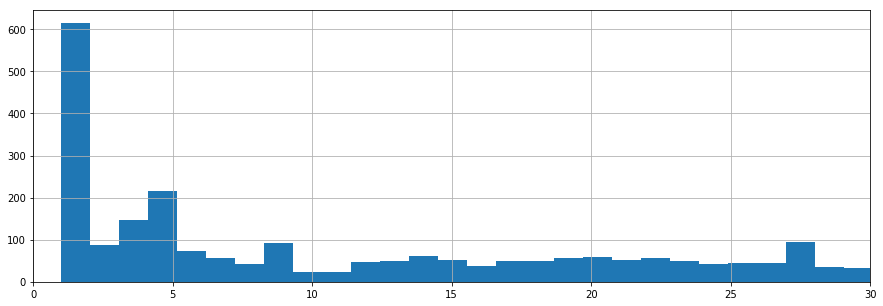

In [65]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [66]:
corpus_tokens_stem[diffs == 5]

array([list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['росс', 'возвраща', 'советск', 'будущ', 'дор']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['стран', 'захотел', 'подня', 'денег', 'пошл']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'н

In [67]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.7379733879222109

In [68]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

2163 2163


In [69]:
print(texts)

['Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа. Национальная стрелковая ассоциация (NRA) вложила в его предвыборную кампанию 36 миллионов долларов. Вскоре после того как Трамп встал во главе страны, продажи резко пошли вниз, а некоторые компании обанкротились. На бизнес усиливается давление — банки отказываются предоставлять кредиты, а крупные фонды бунтуют против инвестиций в оружие, вынуждая оружейников ужесточать доступ к собственной продукции. Крупнокалиберный провал в американской экономике — в материале «Ленты.ру»', 'Кандидат от народа', 'Дональд Трамп стал первым за тридцать лет президентом США, который открыто поддержал Национальную стрелковую ассоциацию (NRA). 29 апреля 2017 года, на сотый день своего правления, он выступил с речью на ее съезде. До него последний раз на такое осмеливался Рональд Рейган в 1983 году. С самого начала предвыборной гонки NRA воспринимала Трампа как своего кандидата и активно его поддержива

In [70]:
print(corpus_tokens_stem)

[['американск', 'производител', 'владельц', 'оруж', 'активн', 'поддержива', 'президентск', 'гонк', 'дональд', 'трамп', 'национальн', 'стрелков', 'ассоциац', 'влож', 'предвыборн', 'кампан', 'доллар', 'вскор', 'трамп', 'встал', 'глав', 'стран', 'продаж', 'резк', 'пошл', 'некотор', 'компан', 'обанкрот', 'бизнес', 'усилива', 'давлен', 'банк', 'отказыва', 'предоставля', 'кредит', 'крупн', 'фонд', 'бунт', 'инвестиц', 'оруж', 'вынужд', 'оружейник', 'ужесточа', 'доступ', 'собствен', 'продукц', 'крупнокалиберн', 'прова', 'американск', 'экономик', 'материал'], ['кандидат', 'народ'], ['дональд', 'трамп', 'перв', 'тридца', 'президент', 'сша', 'открыт', 'поддержа', 'национальн', 'стрелков', 'ассоциац', 'апрел', 'сот', 'правлен', 'выступ', 'реч', 'съезд', 'последн', 'осмелива', 'рональд', 'рейга', 'предвыборн', 'гонк', 'воспринима', 'трамп', 'кандидат', 'активн', 'поддержива', 'частност', 'ассоциац', 'деньг', 'выпуст', 'рекламн', 'ролик', 'выдержа', 'американц', 'предостерега', 'побед', 'кандидат', 

In [71]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

2163 2163


In [72]:
print(texts)

['Американские производители и владельцы оружия активно поддерживали в президентской гонке Дональда Трампа. Национальная стрелковая ассоциация (NRA) вложила в его предвыборную кампанию 36 миллионов долларов. Вскоре после того как Трамп встал во главе страны, продажи резко пошли вниз, а некоторые компании обанкротились. На бизнес усиливается давление — банки отказываются предоставлять кредиты, а крупные фонды бунтуют против инвестиций в оружие, вынуждая оружейников ужесточать доступ к собственной продукции. Крупнокалиберный провал в американской экономике — в материале «Ленты.ру»'
 'Кандидат от народа'
 'Дональд Трамп стал первым за тридцать лет президентом США, который открыто поддержал Национальную стрелковую ассоциацию (NRA). 29 апреля 2017 года, на сотый день своего правления, он выступил с речью на ее съезде. До него последний раз на такое осмеливался Рональд Рейган в 1983 году. С самого начала предвыборной гонки NRA воспринимала Трампа как своего кандидата и активно его поддержива

In [73]:
print(corpus_tokens_stem)

[list(['американск', 'производител', 'владельц', 'оруж', 'активн', 'поддержива', 'президентск', 'гонк', 'дональд', 'трамп', 'национальн', 'стрелков', 'ассоциац', 'влож', 'предвыборн', 'кампан', 'доллар', 'вскор', 'трамп', 'встал', 'глав', 'стран', 'продаж', 'резк', 'пошл', 'некотор', 'компан', 'обанкрот', 'бизнес', 'усилива', 'давлен', 'банк', 'отказыва', 'предоставля', 'кредит', 'крупн', 'фонд', 'бунт', 'инвестиц', 'оруж', 'вынужд', 'оружейник', 'ужесточа', 'доступ', 'собствен', 'продукц', 'крупнокалиберн', 'прова', 'американск', 'экономик', 'материал'])
 list(['кандидат', 'народ'])
 list(['дональд', 'трамп', 'перв', 'тридца', 'президент', 'сша', 'открыт', 'поддержа', 'национальн', 'стрелков', 'ассоциац', 'апрел', 'сот', 'правлен', 'выступ', 'реч', 'съезд', 'последн', 'осмелива', 'рональд', 'рейга', 'предвыборн', 'гонк', 'воспринима', 'трамп', 'кандидат', 'активн', 'поддержива', 'частност', 'ассоциац', 'деньг', 'выпуст', 'рекламн', 'ролик', 'выдержа', 'американц', 'предостерега', 'поб

In [74]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

2163


In [75]:
print(diffs)

[51  2 83 ...  6 50 13]


(0, 10)

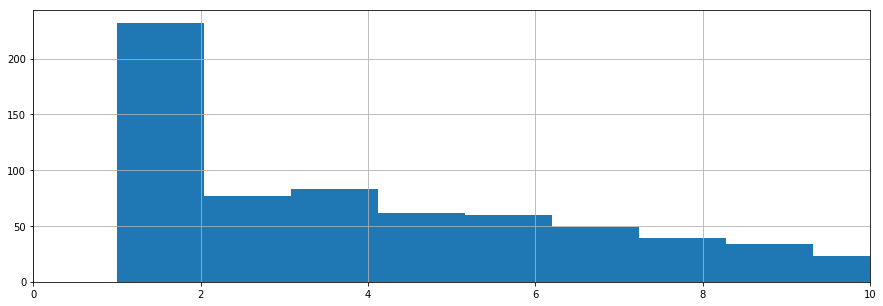

In [76]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [77]:
corpus_tokens_stem[diffs == 7]

array([list(['аутизм', 'год', 'сидел', 'работ', 'зовут', 'лучш', 'компан']),
       list(['россия', 'заставля', 'доплачива', 'миллиард', 'кредит', 'отказа', 'невозможн']),
       list(['стар', 'росс', 'украин', 'нача', 'нов', 'газов', 'войн']),
       list(['обеща', 'защища', 'люд', 'беспредел', 'власт', 'бьют', 'люб']),
       list(['неравенств', 'уничтожа', 'миров', 'экономик', 'учен', 'знает', 'побед']),
       list(['алрос', 'рассказа', 'сопоставим', 'размер', 'алмаз', 'найд', 'половин']),
       list(['россиян', 'хот', 'жит', 'деньг', 'нефт', 'аляск', 'дела']),
       list(['рынок', 'созда', 'илон', 'рад', 'миллиард', 'тесн', 'конкурент']),
       list(['юр', 'борис', 'рассказа', 'производств', 'зависет', 'импортн', 'поставок']),
       list(['сша', 'объяв', 'мир', 'торгов', 'войн', 'побед', 'китайц']),
       list(['сша', 'кита', 'уничтожа', 'друг', 'друг', 'торгов', 'войн']),
       list(['умн', 'вибратор', 'бревн', 'безумств', 'главн', 'выставк', 'технолог']),
       list(['июн

In [78]:
corpus_tokens_stem[diffs >= 8].shape

(1600,)

In [79]:
corp4learning = corpus_tokens_stem[diffs >= 8]
texts4learning = texts[diffs >= 8]

In [80]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [81]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

9093


In [82]:
print(vocab)

['абдува', 'абонентск', 'абрам', 'абрамов', 'абрамович', 'абсолют', 'абсолютн', 'абсурдн', 'авангард', 'авар', 'аварийн', 'август', 'авдот', 'авиабилет', 'авиакомпан', 'авиамоделист', 'авианосн', 'авианосц', 'авиаперевозчик', 'авиапр', 'авиац', 'авиацион', 'авокад', 'австр', 'австрал', 'австралиек', 'австралийск', 'австрийск', 'авт', 'автобус', 'автовокза', 'автоматизац', 'автоматизирова', 'автоматическ', 'автомоб', 'автомобил', 'автомобильн', 'автономн', 'автопроизводител', 'автор', 'авторитетн', 'авторск', 'автотранспорт', 'автошкол', 'агалар', 'агент', 'агентств', 'агитац', 'агитацион', 'агломерац', 'агонизир', 'агресс', 'агрессивн', 'агуреев', 'адамович', 'адаптац', 'адаптирова', 'адвокат', 'адекватн', 'адлерск', 'административн', 'администрац', 'адмира', 'адмиральш', 'адольф', 'адрес', 'адресн', 'адыге', 'ажиотаж', 'азарт', 'азбук', 'азербайджа', 'айнур', 'айов', 'айфон', 'академ', 'академик', 'академическ', 'акватор', 'акил', 'аким', 'аккаунт', 'аккорд', 'аккумулирова', 'аккумуля

In [182]:
print(vocab[3623])

мир


In [84]:
tree1 = ET.ElementTree(file="laba2_file.xml")
root1 = tree1.getroot()

In [94]:
catalogs=root1[0][0]

print(catalogs[49].text)

алекс горде дал поручен компетентн ведомств совместн научн сообществ состав список продукт обязательн порядк обогат витамин микроэлемент сообща рбк ссылк чиновник поручен дан итог заседан межведомствен рабоч групп реализац стратег повышен качеств пищев продукц росс частност планир сдела обязательн сол обогащен молок витамин задач обеспеч люд так продукт необходим содержан витамин микроэлемент поступа полк наш магазин сообщ горде обязательн сол пыта ввест подобн законопроект парт един росс внос госдум пояснительн записк указыва добровольн модел сол оправда экономическ точк зрен использован йодирова поварен сол явля эффективн инвестиц интеллектуальн физическ здоров нац важн новост лент дня подписыва


In [105]:
import csv
our_list=[]
for i in range(200):
    our_list.insert(i, ['data'])
file = open('catalogs.csv', 'w')
with file:
    ww=csv.writer(file)
    ww.writerows(our_list)
print("Done")

Done


In [106]:
DATA = 'catalogs.csv'

In [107]:
df1 = pd.read_csv(DATA, header=None,
                 names=['ttext1'])
print(df1.shape)

(200, 1)


In [108]:
df1.dtypes

ttext1    object
dtype: object

In [109]:
catalogs=root1[0][0]
for i in range(50):
    df1.ttext1[i]=catalogs[i].text
catalogs=root1[0][1]
for i in range(50,100):
    df1.ttext1[i]=catalogs[i-50].text
catalogs=root1[0][2]
for i in range(100,150):
    df1.ttext1[i]=catalogs[i-100].text
catalogs=root1[0][3]
for i in range(150,200):
    df1.ttext1[i]=catalogs[i-150].text

In [110]:
df1.ttext1[50]=catalogs[13].text

In [156]:
df1.head(70)

ttext1
0   американск производител владельц оруж активн п...
1   генпрокуратур проверк размещен соцсет оскорбит...
2   роснефт испытан инновацион полимерн продукт не...
3   газпр отказа привлечен мал средн компан качест...
4   федеральн антимонопольн служб фас официальн пр...
5   аналитик полага российск валют избежа риск воз...
6   президент украин петр порошенк похваста энерге...
7   реализац проект газопровод северн поток больш ...
8   ростелек готов приобрест сотов оператор дан ве...
9   британск автопроизводител разработа сист позво...
10  неравенств доход актуальн проблем универсальн ...
11  роснефт увелич розничн продаж топлив сравнен г...
12  австралийск бюр статистик выяв профессиональн ...
13  глав социальн комитет валер рязанск заяв текущ...
14  власт венесуэл вполн просроч выплат долг росс ...
15  глав втб андр костин категорическ опроверг утв...
16  производител молочн продукц обяза став упаковк...
17  росс отмеча рост цен отдельн товар торгов сет ...
18  крупн последн год алмаз найд месторожден горно...
19  правительств сможет внос изменен крупн инфраст...
20  больш част сопровожда панихид рынк цел стремит...
21  росс увелич количеств поддельн купюр номинал р...
22  российск нефтян компан необходим активн вест р...
23  почт росс котор возглавля никола бывш заместит...
24  техническ решен пересечен северн поток польск ...
25  объем нелегальн операц российск компан иностра...
26  общ выручк компан итог достигл миллиард рубл а...
27  сам популярн лекарств российск аптек оста обез...
28  жалова соцсет отдельн люд цел компан недавн ст...
29  авиакомпан росс вход групп аэрофлот течен янва...
..                                                ...
40  минэкономразвит выступ изменен действ порядк с...
41  лидер оппозиц венесуэл хуа обвин президент ник...
42  компан аэрофлот нача продаж билет величин пари...
43  сотрудник расстройств спектр найт сам прост ра...
44  итог оцен рост строительн индустр процент силь...
45  атмосфер тревог цар прошедш всемирн экономичес...
46  сша предъяв официальн обвинен китайск компан п...
47  бумажн деньг росс появ сравнительн российск по...
48  депутат предлож освобод газпр штраф неустановл...
49  алекс горде дал поручен компетентн ведомств со...
50  начал средн размер выдава росс кредит приобрет...
51  главн инновац мног специалист называ создан см...
52  российск тяжел ударн беспилотн летательн аппар...
53  росс выстро сир вдол границ восточн европ поля...
54  украин способн разрабатыва ракетн вооружен зая...
55  воен бюджет сша действительн сильн соответств ...
56  международн групп астроном зарегистрирова необ...
57  международн групп учен выясн извержен вулкан с...
58  международн групп учен коллаборац руководств ф...
59  ход раскопок подвал историческ здан центр ташк...
60  создан перспективн российск бомбардировщик пак...
61  учен университет штат айов выясн гормон сытост...
62  министерств юстиц разъясн необходим смягчен за...
63  депутат справедлив росс внесл рассмотрен госду...
64  населен росс состав миллион соответств прогноз...
65  депутат госдум бывш прокурор республик крым на...
66  воен произвел бурейск водохранилищ амурск обла...
67  сотрудник типограф миха борисов увол разреш на...
68  владивосток годовал девочк съел гашиш попа реа...
69  чит иркутск эвакуир государствен орга школ бол...

[70 rows x 1 columns]

In [241]:
texts1=[]
for i in range(200):
    sp1 = df1.ttext1[i].split()
   # corpus1.insert(i,sp1)
    texts1.insert(i,sp1)
print(len(texts1[0]))

991


In [242]:
texts1[0]

['американск',
 'производител',
 'владельц',
 'оруж',
 'активн',
 'поддержива',
 'президентск',
 'гонк',
 'дональд',
 'трамп',
 'национальн',
 'стрелков',
 'ассоциац',
 'влож',
 'предвыборн',
 'кампан',
 'доллар',
 'вскор',
 'трамп',
 'встал',
 'глав',
 'стран',
 'продаж',
 'резк',
 'пошл',
 'некотор',
 'компан',
 'обанкрот',
 'бизнес',
 'усилива',
 'давлен',
 'банк',
 'отказыва',
 'предоставля',
 'кредит',
 'крупн',
 'фонд',
 'бунт',
 'инвестиц',
 'оруж',
 'вынужд',
 'оружейник',
 'ужесточа',
 'доступ',
 'собствен',
 'продукц',
 'крупнокалиберн',
 'прова',
 'американск',
 'экономик',
 'материал',
 'кандидат',
 'народ',
 'дональд',
 'трамп',
 'перв',
 'тридца',
 'президент',
 'сша',
 'открыт',
 'поддержа',
 'национальн',
 'стрелков',
 'ассоциац',
 'апрел',
 'сот',
 'правлен',
 'выступ',
 'реч',
 'съезд',
 'последн',
 'осмелива',
 'рональд',
 'рейга',
 'предвыборн',
 'гонк',
 'воспринима',
 'трамп',
 'кандидат',
 'активн',
 'поддержива',
 'частност',
 'ассоциац',
 'деньг',
 'выпуст',
 '

In [243]:
dig=[]
for i in range(200):
    dig.insert(i,len(texts1[i]))
print(len(dig))

200


In [244]:
dig

[991,
 295,
 258,
 107,
 114,
 163,
 116,
 122,
 147,
 126,
 760,
 76,
 99,
 73,
 144,
 122,
 131,
 100,
 89,
 139,
 992,
 122,
 148,
 165,
 107,
 107,
 93,
 81,
 652,
 189,
 949,
 162,
 1039,
 113,
 63,
 97,
 95,
 108,
 120,
 1102,
 100,
 138,
 87,
 1418,
 174,
 312,
 127,
 829,
 87,
 95,
 118,
 624,
 148,
 134,
 154,
 105,
 183,
 138,
 115,
 117,
 78,
 114,
 122,
 158,
 72,
 138,
 58,
 117,
 107,
 120,
 125,
 204,
 1491,
 136,
 82,
 125,
 138,
 1592,
 138,
 91,
 89,
 172,
 80,
 2503,
 116,
 66,
 132,
 98,
 1177,
 1638,
 126,
 93,
 134,
 89,
 1293,
 255,
 128,
 123,
 164,
 374,
 1831,
 624,
 148,
 134,
 154,
 105,
 183,
 138,
 115,
 117,
 78,
 114,
 851,
 114,
 111,
 107,
 111,
 77,
 146,
 139,
 96,
 96,
 2123,
 114,
 115,
 107,
 632,
 110,
 112,
 185,
 94,
 121,
 86,
 158,
 255,
 126,
 44,
 101,
 140,
 50,
 139,
 113,
 106,
 719,
 89,
 103,
 161,
 130,
 98,
 137,
 45,
 468,
 206,
 944,
 127,
 171,
 139,
 224,
 157,
 146,
 135,
 167,
 349,
 118,
 130,
 129,
 122,
 142,
 134,
 106,
 16

In [180]:
for i in range(50):
    for k in range (dig[i]):
        for j in range(9093):
            if texts1[i][k]==vocab[j]:
                texts1[i][k]=j
                print(j)

3623
649
5098
569
6951
36
7004
1108
6747
4145
5754
6951
2066
1371
6209
6951
8823
9
1806
8414
6597
5943
2691
3433
7778
1497
5232
3797
124
725
8087
3642
4079
8403
2468
1813
2280
3663
3891
2730
1806
6562
3922
2405
6780
7653
4513
2802
3716
7738
3595
6967
5750
7745
2793
3569
6026
8734
141
7828
483
6951
7431
1940
1612
2002
6837
8780
4341
4028
3030
6782
1836
2802
3716
4751
911
3205
3595
5602
4773
2802
5917
3637
3935
7744
6171
7983
1939
7738
3643
4520
7745
3546
4453
487
7112
8648
5924
3390
3101
4007
1401
5825
7226
6037
2003
5727
2640
5921
4161
4028
3833
7022
1612
2802
1201
7709
3717
7420
2002
2492
3595
6967
5721
3429
2802
5293
2793
3569
7180
3618
3569
5206
1168
6260
3595
6967
3359
6695
5064
9033
4981
5795
5572
2802
4862
8608
6121
8826
4771
5565
4326
4806
6659
2342
6584
2588
3387
6470
3386
8608
6287
6659
6955
3595
6967
5919
3572
4513
2802
8113
9033
9034
449
1776
8611
4453
4632
8298
4028
6255
1733
5514
6857
4877
2256
144
5921
2481
8315
3357
6659
8315
1551
395
4854
8315
2852
8747
891
7658
6229
38

3125
1153
1754
673
5616
289
8569
5164
9076
8466
2272
3104
2383
846
3595
2793
3569
2002
4257
6148
2802
7180
6948
2462
5726
8569
2004
7790
6946
1009
7226
2676
1501
2272
2221
8093
7659
1775
8569
4241
6289
1144
6260
2802
7794
1776
7659
83
2272
7377
5616
4229
1835
627
4256
8962
7247
4707
611
8569
7791
5931
7697
289
3119
4507
4061
7320
622
4241
5877
6532
2402
7004
4028
3821
5353
8734
5065
2002
4405
7122
4768
1776
7685
7107
595
7424
4254
2405
3493
3879
65
595
4254
3276
1701
5453
7653
9034
6947
1371
3915
2010
1140
6558
4822
5546
1333
9033
1330
3494
8748
6697
7022
1153
1776
7763
846
3716
1932
3109
7653
9034
1371
7539
9033
9033
7509
2168
4822
7434
2271
1140
9034
1776
8186
2600
2002
1371
7685
1191
6558
7653
9034
4256
3718
6793
3716
4341
3966
7539
9033
4816
141
8748
8466
7645
1776
7434
9023
5546
1139
6558
4822
3014
3494
7956
2677
3128
1000
7229
8432
7652
3374
144
5546
49
7539
9033
6558
7434
5173
6452
8748
5476
2002
1162
9033
5917
3716
5194
7785
7180
6947
1371
1932
778
2694
7023
7052
7570
7004
4256

940
4536
9033
6203
5726
8184
1733
2114
5568
2002
1536
8113
9033
8184
1015
5726
8184
1593
9033
3494
7956
7190
4262
4969
1555
4533
8758
1509
2802
5476
2946
2802
9033
4725
7112
1035
6452
5565
4256
2002
1191
9033
6148
5609
6452
5565
3014
7112
1498
7745
1163
5406
141
2946
7710
1333
7699
3716
7707
6260
4439
7336
1593
3996
1550
7022
1612
5921
2002
7745
1164
7798
3595
6967
4813
2946
4405
7122
4768
1776
7685
7107
595
7424
4254
2405
3493
3879
65
595
4254
3276
1701
5453
3420
7674
188
8995
2002
3716
7539
2670
3595
6967
3556
7108
3494
141
6697
7674
7140
188
2802
5293
2793
3569
2002
6695
4507
4932
8995
6659
8724
556
1015
3551
6834
1819
2802
6696
9070
3572
4453
7140
188
3595
6967
3556
8113
3551
7739
188
4536
2802
5293
2793
3569
6659
185
7140
3595
6967
3556
3494
7956
4286
1570
5158
3684
7400
1806
2802
3716
4816
3494
46
1754
2802
3595
6967
3556
1191
7539
4439
4455
8995
5921
6452
3014
2641
7004
188
8995
2002
3716
5952
141
2946
1498
2804
7161
5919
5726
8114
1806
2802
5921
4536
6
4011
189
3981
2063
8736
4

2789
1997
7841
5024
5618
143
7420
3569
3086
8679
2571
3618
8761
4282
8324
8088
1836
7252
3347
7004
4028
2227
3718
8740
2914
4801
7698
3569
4766
7207
5414
6659
7744
4801
3569
6882
3082
1955
6951
8734
1371
6337
5064
3473
1514
5894
5548
6951
8734
2002
6659
7759
6209
8761
4103
6254
7698
3569
2190
3618
7542
7653
3451
8392
5017
2946
8487
5018
7207
1706
7162
8945
7247
1653
1132
5427
7005
2639
4892
7636
3716
5353
1836
7745
2793
3569
3643
2802
4257
4341
7738
6255
1333
5490
7249
2227
8734
7633
7335
7005
5065
2002
1009
4241
9023
5164
6293
8569
4507
5335
6951
2451
2272
4241
2283
765
8734
7794
2002
2946
1108
5352
7739
2802
6733
2599
1717
5948
7431
1664
2946
2062
8734
7865
2227
8584
1811
2593
1914
863
1305
5818
5276
5565
8608
1689
7925
4801
4241
1965
5279
7698
3569
5426
787
7286
6951
7636
8219
7961
7790
4241
4453
3889
2776
8734
5065
7004
4028
7745
6793
4470
5921
1498
3693
2378
5908
7636
974
2272
7446
2085
8734
4241
2002
7247
8222
1689
7893
6978
142
8739
487
4624
8960
7857
3642
6951
8734
2227
5917
84

8960
3823
6951
7739
2942
8805
5544
778
7838
8790
7228
8734
8376
3751
3617
6452
8330
3617
6452
7009
3617
546
3617
4773
2002
6464
948
3138
5862
6951
2942
2933
6275
7988
7739
4816
3623
2802
5568
2942
95
5064
4945
3841
863
723
2593
2802
2784
5565
7942
8945
7247
4536
5281
5601
4885
5276
7636
4221
5936
6951
8734
6669
2676
3811
3718
6659
7022
4044
7875
2942
5064
3551
1819
5737
4241
3716
7653
7674
188
5640
2935
2802
7539
6967
3556
4405
7122
4768
1776
7685
7107
595
7424
4254
2405
3493
3879
65
595
4254
3276
1701
5453
6122
6452
2802
7137
188
3716
8095
3067
6853
4453
4921
693
2499
2378
5341
7108
3494
46
5798
6804
4936
141
8322
2002
6405
7876
1401
7745
192
7645
3832
2802
7452
4365
4421
3536
6853
7421
7542
4439
8823
774
4453
1401
3667
7047
584
7998
3494
7956
4286
1570
5158
3684
7400
1806
2802
3716
3359
940
3380
7348
6501
5665
8406
2962
4067
5876
2549
4083
5895
3380
4453
3956
8727
245
7443
3067
6853
3777
1119
6452
7875
2802
3716
3956
8268
7545
8738
2784
6669
9078
7505
6951
7739
188
2002
7744
1498
141

7348
2272
5928
3112
4877
805
5275
1733
7247
6704
5565
535
2572
2802
4257
2499
5090
2272
6774
6809
2272
2573
6255
3894
8266
2802
6075
6257
582
7205
1670
7004
5743
8266
2190
6260
8009
7145
7004
6704
4638
5919
6122
5599
4256
7868
603
3088
2165
1664
1573
4256
2946
6706
8884
6951
7906
7145
957
4520
7122
5691
2117
1764
7790
863
8089
7004
4256
7756
6774
2802
627
8962
6243
8960
8608
152
3436
4254
7965
863
3205
2802
2593
3174
7831
6974
3307
7855
5565
5379
611
4406
3308
2946
1095
4028
7138
5565
188
1939
6452
1305
4804
3307
2593
5565
3956
5877
189
7421
5876
3451
4533
4885
5790
6795
3551
2011
7008
4491
6083
1597
8891
1603
7014
3307
1810
2593
1141
7674
5750
765
5275
6032
6748
4160
7421
4028
6853
138
3850
4936
7653
6615
5275
5565
7348
3307
8113
2594
611
5440
7286
3390
2628
3121
2650
4917
7622
1840
3977
1498
3307
5919
4257
3482
7161
5490
3451
1017
7004
4507
5846
7855
188
1094
7965
611
6704
4257
5793
5919
4771
6540
1810
2593
6301
2802
4602
4773
1094
4773
7712
7421
189
5617
1116
2272
8701
839
1760
7855

7798
5546
7539
6452
1824
6452
6715
3451
8392
5017
2946
8487
5018
7207
4707
8762
5921
6188
4507
2802
7653
5293
5921
7398
2793
3569
2776
7636
4936
4574
3908
1664
6260
3462
6584
6188
1593
2115
7145
8595
940
8608
1906
2930
723
4257
3482
7161
3718
6793
8496
6069
4241
3716
7483
5293
2002
2168
5750
7653
5293
2802
4257
7745
6793
7398
6122
8823
7865
2462
7795
5921
6715
1664
3462
6638
6280
1689
8723
8219
1754
1528
7481
1754
3647
2802
7653
5293
5956
8011
1776
2982
8063
2386
8001
7790
7539
6452
2793
3569
1250
1664
46
4028
493
8043
3946
3193
7161
2962
5818
5293
2793
3569
7397
7022
4954
2793
3569
6452
4465
2462
2790
8658
1498
7161
8106
5850
972
7360
4405
1836
2593
6039
6951
7636
6395
2002
6951
7675
2004
3119
670
3163
7112
7653
7004
7674
1140
6453
6497
6040
4963
5276
7636
8723
8420
4705
1882
7653
5293
2802
6274
7396
6289
4756
8570
863
5565
8608
1906
2930
7963
7483
5293
2802
4241
6289
6274
7452
147
2165
1250
1664
3462
6838
316
8537
8466
6289
3604
5293
5921
5173
6774
7398
2793
3569
673
4241
6289
879
17

In [181]:
texts1[0]

[3623,
 649,
 5098,
 569,
 6951,
 36,
 7004,
 1108,
 6747,
 4145,
 5754,
 6951,
 2066,
 1371,
 6209,
 6951,
 8823,
 9,
 1806,
 8414,
 6597,
 5943,
 2691,
 3433,
 7778,
 1497,
 5232,
 3797,
 124,
 725,
 8087,
 3642,
 4079,
 8403,
 2468,
 1813,
 2280,
 3663,
 3891,
 2730,
 1806,
 6562,
 3922,
 2405,
 6780]

In [151]:
import xml.etree.ElementTree as xml

root = xml.Element("root")
catalogs = xml.Element("catalogs")
root.append(catalogs)

for i in range(4):
    catalog = xml.SubElement(catalogs, "catalog")
    catalog_number=catalog.set('number',str(i))
    for j in range(50):
        article = xml.SubElement(catalog, "article")
        article_number=article.set('number',str(j))
        article.text = "RRR"    
    
tree = xml.ElementTree(root)
tree.write("laba2_file_dig.xml", encoding = "UTF-8", xml_declaration = True)

In [183]:
for i in range(50):
    catalog=catalogs[3];
    article=catalog[i];
    full_data = ' '.join(str(x) for x in texts1[i])
    #full_data=full_data.replace('\'','').replace('[','').replace(']','')
    if ( article.attrib['number'] == str(i) ):
        article.text = full_data
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [184]:
tree = xml.ElementTree(root)
tree.write("laba2_file_dig.xml", encoding = "UTF-8", xml_declaration = True)

In [197]:
for i in range(50): 
    catalog=catalogs[3]; 
    article=catalog[i]; 
    result = re.findall(r'\d+',article.text) 
    new_full_data = ' '.join(str(x) for x in result) 
    if ( article.attrib['number'] == str(i) ): 
        article.text = new_full_data 
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [198]:
tree = xml.ElementTree(root) 
tree.write("laba2_file_dig.xml", encoding = "UTF-8", xml_declaration = True)

In [245]:
texts1

[['американск',
  'производител',
  'владельц',
  'оруж',
  'активн',
  'поддержива',
  'президентск',
  'гонк',
  'дональд',
  'трамп',
  'национальн',
  'стрелков',
  'ассоциац',
  'влож',
  'предвыборн',
  'кампан',
  'доллар',
  'вскор',
  'трамп',
  'встал',
  'глав',
  'стран',
  'продаж',
  'резк',
  'пошл',
  'некотор',
  'компан',
  'обанкрот',
  'бизнес',
  'усилива',
  'давлен',
  'банк',
  'отказыва',
  'предоставля',
  'кредит',
  'крупн',
  'фонд',
  'бунт',
  'инвестиц',
  'оруж',
  'вынужд',
  'оружейник',
  'ужесточа',
  'доступ',
  'собствен',
  'продукц',
  'крупнокалиберн',
  'прова',
  'американск',
  'экономик',
  'материал',
  'кандидат',
  'народ',
  'дональд',
  'трамп',
  'перв',
  'тридца',
  'президент',
  'сша',
  'открыт',
  'поддержа',
  'национальн',
  'стрелков',
  'ассоциац',
  'апрел',
  'сот',
  'правлен',
  'выступ',
  'реч',
  'съезд',
  'последн',
  'осмелива',
  'рональд',
  'рейга',
  'предвыборн',
  'гонк',
  'воспринима',
  'трамп',
  'кандида

In [300]:
import collections
def compute_tf(text):
#На вход берем текст в виде списка (list) слов
    #Считаем частотность всех терминов во входном массиве с помощью 
    #метода Counter библиотеки collections
    tf_text = collections.Counter(text)
    for i in tf_text:
        #для каждого слова в tf_text считаем TF путём деления
        #встречаемости слова на общее количество слов в тексте
         tf_text[i] = tf_text[i]/float(len(text))
    #возвращаем объект типа Counter c TF всех слов текста
    return tf_text
for i in range(200):
    text=texts1[i]
    print (compute_tf(text))

Counter({'оруж': 0.03733602421796166, 'компан': 0.020181634712411706, 'продаж': 0.016145307769929364, 'трамп': 0.010090817356205853, 'оружейн': 0.010090817356205853, 'миллион': 0.009081735620585268, 'процент': 0.009081735620585268, 'доллар': 0.008072653884964682, 'огнестрельн': 0.008072653884964682, 'производител': 0.007063572149344097, 'банк': 0.006054490413723511, 'стал': 0.006054490413723511, 'отрасл': 0.006054490413723511, 'производств': 0.006054490413723511, 'ассоциац': 0.005045408678102927, 'сша': 0.005045408678102927, 'частност': 0.005045408678102927, 'поправк': 0.005045408678102927, 'фот': 0.005045408678102927, 'власт': 0.005045408678102927, 'год': 0.005045408678102927, 'обам': 0.005045408678102927, 'поддержива': 0.004036326942482341, 'резк': 0.004036326942482341, 'бизнес': 0.004036326942482341, 'крупн': 0.004036326942482341, 'фонд': 0.004036326942482341, 'материал': 0.004036326942482341, 'президент': 0.004036326942482341, 'клинтон': 0.004036326942482341, 'политик': 0.004036326

Counter({'сделк': 0.047619047619047616, 'миллиард': 0.034013605442176874, 'рубл': 0.034013605442176874, 'ростелек': 0.027210884353741496, 'дан': 0.027210884353741496, 'оператор': 0.02040816326530612, 'счита': 0.02040816326530612, 'мобильн': 0.02040816326530612, 'баз': 0.02040816326530612, 'сотов': 0.013605442176870748, 'издан': 0.013605442176870748, 'сторон': 0.013605442176870748, 'эксперт': 0.013605442176870748, 'польз': 0.013605442176870748, 'связ': 0.013605442176870748, 'состо': 0.013605442176870748, 'борзов': 0.013605442176870748, 'ростелеком': 0.013605442176870748, 'рынк': 0.013605442176870748, 'аналитик': 0.013605442176870748, 'больш': 0.013605442176870748, 'выручк': 0.013605442176870748, 'крупн': 0.013605442176870748, 'российск': 0.013605442176870748, 'телеком': 0.013605442176870748, 'абонентск': 0.013605442176870748, 'готов': 0.006802721088435374, 'приобрест': 0.006802721088435374, 'ведом': 0.006802721088435374, 'оценива': 0.006802721088435374, 'источник': 0.006802721088435374,

Counter({'проект': 0.04672897196261682, 'трубопровод': 0.028037383177570093, 'техническ': 0.018691588785046728, 'северн': 0.018691588785046728, 'поток': 0.018691588785046728, 'польск': 0.018691588785046728, 'соглашен': 0.018691588785046728, 'газпром': 0.018691588785046728, 'газопровод': 0.018691588785046728, 'балтийск': 0.018691588785046728, 'мор': 0.018691588785046728, 'решен': 0.009345794392523364, 'пересечен': 0.009345794392523364, 'слож': 0.009345794392523364, 'газов': 0.009345794392523364, 'отрасл': 0.009345794392523364, 'практик': 0.009345794392523364, 'определ': 0.009345794392523364, 'оператор': 0.009345794392523364, 'объект': 0.009345794392523364, 'переда': 0.009345794392523364, 'рбк': 0.009345794392523364, 'вторник': 0.009345794392523364, 'январ': 0.009345794392523364, 'ссылк': 0.009345794392523364, 'компан': 0.009345794392523364, 'прокомментирова': 0.009345794392523364, 'публикац': 0.009345794392523364, 'сообща': 0.009345794392523364, 'необходим': 0.009345794392523364, 'согла

Counter({'охотник': 0.0472972972972973, 'российск': 0.033783783783783786, 'разработк': 0.02027027027027027, 'тяжел': 0.013513513513513514, 'ударн': 0.013513513513513514, 'аппарат': 0.013513513513513514, 'поступ': 0.013513513513513514, 'вооружен': 0.013513513513513514, 'заяв': 0.013513513513513514, 'потреб': 0.013513513513513514, 'боев': 0.013513513513513514, 'январ': 0.013513513513513514, 'появ': 0.013513513513513514, 'перв': 0.013513513513513514, 'росс': 0.013513513513513514, 'скорост': 0.013513513513513514, 'километр': 0.013513513513513514, 'час': 0.013513513513513514, 'сша': 0.013513513513513514, 'работ': 0.013513513513513514, 'оценива': 0.013513513513513514, 'беспилотн': 0.006756756756756757, 'летательн': 0.006756756756756757, 'высок': 0.006756756756756757, 'вероятн': 0.006756756756756757, 'рф': 0.006756756756756757, 'пишет': 0.006756756756756757, 'американск': 0.006756756756756757, 'журнал': 0.006756756756756757, 'эксперт': 0.006756756756756757, 'воен': 0.006756756756756757, 'авиа

Counter({'тизяк': 0.045454545454545456, 'ссср': 0.045454545454545456, 'возраст': 0.030303030303030304, 'умер': 0.030303030303030304, 'новост': 0.030303030303030304, 'государствен': 0.030303030303030304, 'член': 0.030303030303030304, 'январ': 0.030303030303030304, 'екатеринбург': 0.015151515151515152, 'советск': 0.015151515151515152, 'политическ': 0.015151515151515152, 'деятел': 0.015151515151515152, 'александр': 0.015151515151515152, 'сообща': 0.015151515151515152, 'ри': 0.015151515151515152, 'ушел': 0.015151515151515152, 'жизн': 0.015151515151515152, 'суббот': 0.015151515151515152, 'числ': 0.015151515151515152, 'известн': 0.015151515151515152, 'смерт': 0.015151515151515152, 'стал': 0.015151515151515152, 'возглав': 0.015151515151515152, 'ассоциац': 0.015151515151515152, 'предприят': 0.015151515151515152, 'объект': 0.015151515151515152, 'промышлен': 0.015151515151515152, 'строительств': 0.015151515151515152, 'транспорт': 0.015151515151515152, 'связ': 0.015151515151515152, 'впоследств': 

Counter({'ген': 0.043859649122807015, 'устойчив': 0.03508771929824561, 'днк': 0.03508771929824561, 'учен': 0.02631578947368421, 'антибиотик': 0.02631578947368421, 'выявл': 0.02631578947368421, 'микроорганизм': 0.02631578947368421, 'обнаруж': 0.017543859649122806, 'шпицберг': 0.017543859649122806, 'образц': 0.017543859649122806, 'почв': 0.017543859649122806, 'включ': 0.017543859649122806, 'бактер': 0.017543859649122806, 'так': 0.017543859649122806, 'патоген': 0.017543859649122806, 'университет': 0.008771929824561403, 'великобритан': 0.008771929824561403, 'залив': 0.008771929824561403, 'архипелаг': 0.008771929824561403, 'первоначальн': 0.008771929824561403, 'больниц': 0.008771929824561403, 'инд': 0.008771929824561403, 'сообща': 0.008771929824561403, 'ход': 0.008771929824561403, 'анализ': 0.008771929824561403, 'сорок': 0.008771929824561403, 'восьм': 0.008771929824561403, 'точек': 0.008771929824561403, 'сбор': 0.008771929824561403, 'установ': 0.008771929824561403, 'последовательн': 0.00877

Counter({'жил': 0.02631578947368421, 'материал': 0.019736842105263157, 'арендн': 0.019736842105263157, 'ставк': 0.019736842105263157, 'го': 0.019736842105263157, 'стал': 0.019736842105263157, 'съемн': 0.013157894736842105, 'квартир': 0.013157894736842105, 'москв': 0.013157894736842105, 'торг': 0.013157894736842105, 'арендатор': 0.013157894736842105, 'агентств': 0.013157894736842105, 'дополнительн': 0.013157894736842105, 'рынк': 0.013157894736842105, 'средн': 0.013157894736842105, 'важн': 0.013157894736842105, 'новост': 0.013157894736842105, 'собственник': 0.006578947368421052, 'недорог': 0.006578947368421052, 'переста': 0.006578947368421052, 'соглаша': 0.006578947368421052, 'потенциальн': 0.006578947368421052, 'отмеча': 0.006578947368421052, 'предоставлен': 0.006578947368421052, 'редакц': 0.006578947368421052, 'сегмент': 0.006578947368421052, 'скидок': 0.006578947368421052, 'констатир': 0.006578947368421052, 'редк': 0.006578947368421052, 'случа': 0.006578947368421052, 'хозяев': 0.00657

In [299]:
import math
texts=texts1
def compute_idf(word, corpus):
#на вход берется слово, для которого считаем IDF
#и корпус документов в виде списка списков слов
        #количество документов, где встречается искомый термин
        #считается как генератор списков
    return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))
for i in range(len(vocab)):
        print(i)
        word=vocab[i]
        print (compute_idf(word, texts))

0
2.3010299956639813
1
2.3010299956639813
2
2.3010299956639813
3
2.3010299956639813
4
2.3010299956639813
5
2.3010299956639813
6
1.1549019599857433
7
2.3010299956639813
8
1.8239087409443189
9
1.4559319556497243
10
2.0
11
1.1870866433571445
12
2.3010299956639813
13
2.0
14
1.6989700043360187
15
2.3010299956639813
16
2.3010299956639813
17
2.3010299956639813
18
1.8239087409443189
19
2.3010299956639813
20
1.2596373105057561
21
1.3467874862246563
22
2.3010299956639813
23
2.3010299956639813
24
2.0
25
2.3010299956639813
26
2.3010299956639813
27
2.0
28
2.3010299956639813
29
1.8239087409443189
30
2.3010299956639813
31
2.3010299956639813
32
2.3010299956639813
33
1.6989700043360187
34
2.3010299956639813
35
1.1870866433571445
36
1.6989700043360187
37
1.6020599913279623
38
2.3010299956639813
39
1.045757490560675
40
2.3010299956639813
41
2.3010299956639813
42
2.3010299956639813
43
2.3010299956639813
44
2.3010299956639813
45
2.0
46
0.7569619513137056
47
2.3010299956639813
48
2.3010299956639813
49
2.301

1.6020599913279623
436
2.3010299956639813
437
2.3010299956639813
438
2.3010299956639813
439
1.8239087409443189
440
1.8239087409443189
441
1.6020599913279623
442
2.0
443
2.3010299956639813
444
2.3010299956639813
445
2.0
446
2.3010299956639813
447
2.3010299956639813
448
2.3010299956639813
449
2.0
450
2.3010299956639813
451
2.3010299956639813
452
1.6989700043360187
453
1.5228787452803376
454
2.3010299956639813
455
2.3010299956639813
456
1.8239087409443189
457
2.3010299956639813
458
2.3010299956639813
459
2.0
460
1.2218487496163564
461
2.0
462
2.3010299956639813
463
2.3010299956639813
464
2.3010299956639813
465
1.5228787452803376
466
2.3010299956639813
467
2.3010299956639813
468
2.3010299956639813
469
2.3010299956639813
470
2.3010299956639813
471
1.8239087409443189
472
1.6020599913279623
473
2.0
474
1.3467874862246563
475
2.0
476
2.3010299956639813
477
2.3010299956639813
478
2.3010299956639813
479
2.3010299956639813
480
1.3010299956639813
481
1.4559319556497243
482
2.3010299956639813
483
0

1.8239087409443189
866
2.3010299956639813
867
2.3010299956639813
868
2.3010299956639813
869
1.2596373105057561
870
1.6989700043360187
871
2.3010299956639813
872
2.0
873
2.3010299956639813
874
2.3010299956639813
875
2.3010299956639813
876
2.3010299956639813
877
1.1249387366083
878
2.3010299956639813
879
2.3010299956639813
880
2.3010299956639813
881
2.0
882
2.3010299956639813
883
1.8239087409443189
884
2.3010299956639813
885
2.0
886
1.8239087409443189
887
2.3010299956639813
888
2.3010299956639813
889
2.3010299956639813
890
2.3010299956639813
891
2.3010299956639813
892
1.1249387366083
893
1.6989700043360187
894
2.3010299956639813
895
2.0
896
2.3010299956639813
897
2.3010299956639813
898
2.3010299956639813
899
1.5228787452803376
900
1.6989700043360187
901
2.3010299956639813
902
2.0
903
1.8239087409443189
904
2.3010299956639813
905
2.3010299956639813
906
1.045757490560675
907
2.3010299956639813
908
1.1549019599857433
909
2.3010299956639813
910
2.0
911
0.8096683018297085
912
2.30102999566398

1266
2.0
1267
2.3010299956639813
1268
2.3010299956639813
1269
2.3010299956639813
1270
1.6989700043360187
1271
1.3010299956639813
1272
2.3010299956639813
1273
2.3010299956639813
1274
2.3010299956639813
1275
1.5228787452803376
1276
2.0
1277
2.3010299956639813
1278
2.3010299956639813
1279
2.0
1280
1.6989700043360187
1281
2.3010299956639813
1282
1.8239087409443189
1283
2.0
1284
2.0
1285
1.6989700043360187
1286
1.6020599913279623
1287
2.3010299956639813
1288
2.3010299956639813
1289
2.3010299956639813
1290
2.3010299956639813
1291
2.3010299956639813
1292
2.3010299956639813
1293
1.6989700043360187
1294
2.3010299956639813
1295
2.3010299956639813
1296
2.3010299956639813
1297
2.0
1298
2.0
1299
2.3010299956639813
1300
2.3010299956639813
1301
2.3010299956639813
1302
0.6777807052660807
1303
2.3010299956639813
1304
2.3010299956639813
1305
0.7825160557860937
1306
2.3010299956639813
1307
1.4559319556497243
1308
2.3010299956639813
1309
2.3010299956639813
1310
2.3010299956639813
1311
2.3010299956639813
1

2.3010299956639813
1681
2.0
1682
2.3010299956639813
1683
2.3010299956639813
1684
2.3010299956639813
1685
2.0
1686
2.0
1687
2.0
1688
1.4559319556497243
1689
1.045757490560675
1690
2.0
1691
1.5228787452803376
1692
1.1549019599857433
1693
1.8239087409443189
1694
2.3010299956639813
1695
2.3010299956639813
1696
2.3010299956639813
1697
1.8239087409443189
1698
2.0
1699
2.0
1700
2.0
1701
0.10790539730951963
1702
2.3010299956639813
1703
2.0
1704
1.3010299956639813
1705
1.0705810742857074
1706
2.0
1707
2.0
1708
1.4559319556497243
1709
2.3010299956639813
1710
1.6989700043360187
1711
1.8239087409443189
1712
1.8239087409443189
1713
2.0
1714
2.3010299956639813
1715
2.3010299956639813
1716
2.3010299956639813
1717
1.8239087409443189
1718
2.3010299956639813
1719
2.3010299956639813
1720
1.6020599913279623
1721
2.3010299956639813
1722
2.3010299956639813
1723
2.0
1724
2.3010299956639813
1725
2.3010299956639813
1726
2.3010299956639813
1727
2.3010299956639813
1728
2.3010299956639813
1729
2.3010299956639813


2127
2.3010299956639813
2128
2.3010299956639813
2129
2.3010299956639813
2130
2.0
2131
2.3010299956639813
2132
2.3010299956639813
2133
2.3010299956639813
2134
1.4559319556497243
2135
2.3010299956639813
2136
1.5228787452803376
2137
1.8239087409443189
2138
2.0
2139
2.3010299956639813
2140
1.6989700043360187
2141
2.3010299956639813
2142
2.3010299956639813
2143
2.3010299956639813
2144
2.3010299956639813
2145
2.3010299956639813
2146
2.0
2147
2.0
2148
2.3010299956639813
2149
2.3010299956639813
2150
2.3010299956639813
2151
2.3010299956639813
2152
2.0
2153
2.3010299956639813
2154
2.0
2155
2.3010299956639813
2156
1.8239087409443189
2157
1.5228787452803376
2158
2.3010299956639813
2159
2.0
2160
2.3010299956639813
2161
2.3010299956639813
2162
2.3010299956639813
2163
2.3010299956639813
2164
2.3010299956639813
2165
1.0969100130080565
2166
1.5228787452803376
2167
2.3010299956639813
2168
1.0969100130080565
2169
2.3010299956639813
2170
2.0
2171
1.8239087409443189
2172
2.0
2173
1.6989700043360187
2174
2.

1.2218487496163564
2529
2.3010299956639813
2530
2.3010299956639813
2531
1.6989700043360187
2532
1.3467874862246563
2533
2.3010299956639813
2534
1.6989700043360187
2535
2.3010299956639813
2536
1.4559319556497243
2537
2.0
2538
2.3010299956639813
2539
1.8239087409443189
2540
2.3010299956639813
2541
2.3010299956639813
2542
2.3010299956639813
2543
1.6989700043360187
2544
2.0
2545
1.1870866433571445
2546
2.3010299956639813
2547
2.3010299956639813
2548
1.8239087409443189
2549
2.3010299956639813
2550
1.8239087409443189
2551
1.6989700043360187
2552
1.4559319556497243
2553
2.3010299956639813
2554
1.8239087409443189
2555
2.3010299956639813
2556
2.3010299956639813
2557
2.0
2558
2.0
2559
1.1249387366083
2560
2.3010299956639813
2561
2.3010299956639813
2562
1.6989700043360187
2563
1.3010299956639813
2564
2.3010299956639813
2565
2.3010299956639813
2566
2.3010299956639813
2567
1.5228787452803376
2568
1.8239087409443189
2569
2.0
2570
1.8239087409443189
2571
2.3010299956639813
2572
0.958607314841775
2573

2930
1.3979400086720377
2931
1.4559319556497243
2932
1.8239087409443189
2933
2.3010299956639813
2934
2.3010299956639813
2935
1.6020599913279623
2936
2.3010299956639813
2937
2.3010299956639813
2938
1.6020599913279623
2939
2.3010299956639813
2940
2.0
2941
2.3010299956639813
2942
1.2596373105057561
2943
2.3010299956639813
2944
2.3010299956639813
2945
2.0
2946
0.5086383061657272
2947
2.3010299956639813
2948
1.8239087409443189
2949
1.8239087409443189
2950
2.3010299956639813
2951
0.958607314841775
2952
1.8239087409443189
2953
1.8239087409443189
2954
2.0
2955
1.8239087409443189
2956
2.3010299956639813
2957
1.6989700043360187
2958
2.3010299956639813
2959
2.0
2960
2.3010299956639813
2961
2.3010299956639813
2962
1.5228787452803376
2963
1.8239087409443189
2964
1.6989700043360187
2965
2.3010299956639813
2966
1.6989700043360187
2967
2.3010299956639813
2968
2.0
2969
1.6020599913279623
2970
1.4559319556497243
2971
1.6989700043360187
2972
2.0
2973
2.3010299956639813
2974
1.4559319556497243
2975
1.8239

2.3010299956639813
3339
2.0
3340
2.3010299956639813
3341
1.6989700043360187
3342
2.3010299956639813
3343
2.0
3344
2.3010299956639813
3345
2.0
3346
2.3010299956639813
3347
1.8239087409443189
3348
2.3010299956639813
3349
2.0
3350
2.3010299956639813
3351
2.0
3352
2.3010299956639813
3353
2.3010299956639813
3354
2.3010299956639813
3355
2.3010299956639813
3356
2.3010299956639813
3357
2.3010299956639813
3358
2.3010299956639813
3359
1.4559319556497243
3360
2.3010299956639813
3361
2.3010299956639813
3362
2.0
3363
2.3010299956639813
3364
2.3010299956639813
3365
2.3010299956639813
3366
2.3010299956639813
3367
2.3010299956639813
3368
2.3010299956639813
3369
2.3010299956639813
3370
2.3010299956639813
3371
2.3010299956639813
3372
2.3010299956639813
3373
2.0
3374
1.0705810742857074
3375
1.6989700043360187
3376
1.8239087409443189
3377
2.0
3378
2.3010299956639813
3379
2.3010299956639813
3380
0.8696662315049939
3381
2.3010299956639813
3382
2.3010299956639813
3383
2.3010299956639813
3384
1.82390874094431

3722
2.0
3723
2.3010299956639813
3724
2.0
3725
2.3010299956639813
3726
2.3010299956639813
3727
2.3010299956639813
3728
1.8239087409443189
3729
2.3010299956639813
3730
1.6989700043360187
3731
2.0
3732
1.2596373105057561
3733
1.4559319556497243
3734
2.3010299956639813
3735
2.3010299956639813
3736
2.3010299956639813
3737
1.3467874862246563
3738
2.3010299956639813
3739
2.3010299956639813
3740
2.3010299956639813
3741
2.3010299956639813
3742
1.3467874862246563
3743
2.0
3744
2.3010299956639813
3745
2.0
3746
2.3010299956639813
3747
2.3010299956639813
3748
2.3010299956639813
3749
2.3010299956639813
3750
1.8239087409443189
3751
1.8239087409443189
3752
2.3010299956639813
3753
2.0
3754
2.3010299956639813
3755
1.8239087409443189
3756
2.3010299956639813
3757
1.8239087409443189
3758
2.3010299956639813
3759
2.0
3760
1.8239087409443189
3761
1.8239087409443189
3762
2.0
3763
2.0
3764
1.6989700043360187
3765
2.3010299956639813
3766
2.3010299956639813
3767
1.6020599913279623
3768
1.6989700043360187
3769
2.

4142
2.3010299956639813
4143
2.0
4144
2.3010299956639813
4145
1.6989700043360187
4146
2.3010299956639813
4147
2.3010299956639813
4148
1.8239087409443189
4149
2.3010299956639813
4150
2.3010299956639813
4151
1.6989700043360187
4152
2.3010299956639813
4153
2.3010299956639813
4154
2.3010299956639813
4155
1.6989700043360187
4156
2.3010299956639813
4157
2.3010299956639813
4158
2.0
4159
2.3010299956639813
4160
2.0
4161
1.2596373105057561
4162
2.3010299956639813
4163
2.3010299956639813
4164
1.1870866433571445
4165
2.0
4166
2.3010299956639813
4167
2.3010299956639813
4168
2.3010299956639813
4169
2.3010299956639813
4170
2.3010299956639813
4171
2.3010299956639813
4172
1.8239087409443189
4173
1.6989700043360187
4174
2.3010299956639813
4175
1.8239087409443189
4176
2.0
4177
1.8239087409443189
4178
2.0
4179
2.3010299956639813
4180
2.3010299956639813
4181
1.8239087409443189
4182
2.3010299956639813
4183
2.3010299956639813
4184
2.3010299956639813
4185
2.3010299956639813
4186
2.0
4187
1.6989700043360187
4

2.3010299956639813
4544
1.8239087409443189
4545
2.0
4546
2.0
4547
2.0
4548
1.6020599913279623
4549
1.8239087409443189
4550
2.3010299956639813
4551
2.3010299956639813
4552
2.3010299956639813
4553
2.3010299956639813
4554
2.3010299956639813
4555
2.3010299956639813
4556
1.8239087409443189
4557
2.3010299956639813
4558
1.5228787452803376
4559
2.3010299956639813
4560
2.0
4561
1.6989700043360187
4562
2.0
4563
1.0222763947111522
4564
1.8239087409443189
4565
2.3010299956639813
4566
2.0
4567
2.3010299956639813
4568
2.3010299956639813
4569
1.8239087409443189
4570
2.3010299956639813
4571
2.3010299956639813
4572
2.3010299956639813
4573
2.3010299956639813
4574
1.3979400086720377
4575
2.0
4576
2.3010299956639813
4577
2.3010299956639813
4578
2.3010299956639813
4579
2.3010299956639813
4580
2.3010299956639813
4581
2.3010299956639813
4582
2.3010299956639813
4583
2.3010299956639813
4584
2.0
4585
2.0
4586
2.0
4587
1.1549019599857433
4588
2.3010299956639813
4589
1.4559319556497243
4590
1.3979400086720377
459

2.3010299956639813
4949
2.3010299956639813
4950
1.6020599913279623
4951
2.0
4952
2.3010299956639813
4953
1.8239087409443189
4954
1.6020599913279623
4955
1.6989700043360187
4956
1.6989700043360187
4957
2.3010299956639813
4958
1.5228787452803376
4959
1.8239087409443189
4960
2.3010299956639813
4961
2.3010299956639813
4962
1.3010299956639813
4963
1.3010299956639813
4964
2.0
4965
1.6989700043360187
4966
2.3010299956639813
4967
1.5228787452803376
4968
2.0
4969
2.0
4970
2.3010299956639813
4971
2.3010299956639813
4972
2.3010299956639813
4973
1.5228787452803376
4974
1.6020599913279623
4975
1.3010299956639813
4976
2.0
4977
1.8239087409443189
4978
2.0
4979
2.3010299956639813
4980
1.6020599913279623
4981
1.8239087409443189
4982
1.8239087409443189
4983
2.3010299956639813
4984
2.3010299956639813
4985
2.0
4986
2.3010299956639813
4987
2.3010299956639813
4988
1.8239087409443189
4989
2.3010299956639813
4990
2.0
4991
1.1249387366083
4992
2.0
4993
2.3010299956639813
4994
2.0
4995
2.3010299956639813
4996
1

5410
2.3010299956639813
5411
2.3010299956639813
5412
2.3010299956639813
5413
2.3010299956639813
5414
2.3010299956639813
5415
2.3010299956639813
5416
2.0
5417
2.0
5418
2.0
5419
1.8239087409443189
5420
2.3010299956639813
5421
2.3010299956639813
5422
2.3010299956639813
5423
2.0
5424
2.3010299956639813
5425
2.3010299956639813
5426
1.6020599913279623
5427
2.0
5428
2.3010299956639813
5429
1.8239087409443189
5430
2.3010299956639813
5431
1.6020599913279623
5432
0.8860566476931633
5433
2.3010299956639813
5434
2.3010299956639813
5435
2.0
5436
2.3010299956639813
5437
1.8239087409443189
5438
2.3010299956639813
5439
2.3010299956639813
5440
2.3010299956639813
5441
2.3010299956639813
5442
2.3010299956639813
5443
2.3010299956639813
5444
1.1549019599857433
5445
2.3010299956639813
5446
2.0
5447
1.8239087409443189
5448
2.0
5449
1.4559319556497243
5450
2.0
5451
1.8239087409443189
5452
2.3010299956639813
5453
0.1106982974936897
5454
2.3010299956639813
5455
2.0
5456
2.3010299956639813
5457
1.823908740944318

2.0
5910
2.3010299956639813
5911
1.8239087409443189
5912
2.0
5913
2.3010299956639813
5914
1.4559319556497243
5915
2.3010299956639813
5916
1.6020599913279623
5917
1.1870866433571445
5918
2.3010299956639813
5919
0.8860566476931633
5920
1.1870866433571445
5921
0.9208187539523752
5922
1.3467874862246563
5923
1.6989700043360187
5924
1.8239087409443189
5925
1.3010299956639813
5926
2.3010299956639813
5927
1.3467874862246563
5928
1.6989700043360187
5929
2.3010299956639813
5930
1.8239087409443189
5931
1.1249387366083
5932
1.6020599913279623
5933
1.8239087409443189
5934
2.0
5935
2.3010299956639813
5936
2.3010299956639813
5937
2.3010299956639813
5938
2.3010299956639813
5939
1.8239087409443189
5940
1.8239087409443189
5941
2.3010299956639813
5942
2.3010299956639813
5943
1.8239087409443189
5944
1.4559319556497243
5945
1.8239087409443189
5946
2.3010299956639813
5947
1.045757490560675
5948
1.2218487496163564
5949
1.8239087409443189
5950
2.3010299956639813
5951
2.3010299956639813
5952
1.187086643357144

1.6989700043360187
6435
1.3979400086720377
6436
1.8239087409443189
6437
2.0
6438
2.3010299956639813
6439
2.0
6440
1.6989700043360187
6441
2.3010299956639813
6442
1.8239087409443189
6443
2.3010299956639813
6444
2.0
6445
2.3010299956639813
6446
1.1870866433571445
6447
2.3010299956639813
6448
2.0
6449
2.3010299956639813
6450
2.3010299956639813
6451
2.3010299956639813
6452
0.638272163982407
6453
1.6989700043360187
6454
1.045757490560675
6455
2.3010299956639813
6456
1.2596373105057561
6457
2.3010299956639813
6458
2.3010299956639813
6459
2.0
6460
1.8239087409443189
6461
2.3010299956639813
6462
2.0
6463
1.8239087409443189
6464
0.638272163982407
6465
1.5228787452803376
6466
2.3010299956639813
6467
1.8239087409443189
6468
1.6989700043360187
6469
2.0
6470
2.3010299956639813
6471
2.0
6472
2.3010299956639813
6473
1.5228787452803376
6474
2.3010299956639813
6475
2.3010299956639813
6476
2.0
6477
2.0
6478
2.3010299956639813
6479
2.3010299956639813
6480
1.8239087409443189
6481
1.4559319556497243
6482
2

1.1549019599857433
6893
1.1870866433571445
6894
0.8860566476931633
6895
2.3010299956639813
6896
2.3010299956639813
6897
2.3010299956639813
6898
2.0
6899
1.0705810742857074
6900
2.3010299956639813
6901
2.0
6902
2.3010299956639813
6903
2.3010299956639813
6904
2.0
6905
2.3010299956639813
6906
1.4559319556497243
6907
2.3010299956639813
6908
1.8239087409443189
6909
2.3010299956639813
6910
1.6989700043360187
6911
2.0
6912
1.2218487496163564
6913
2.0
6914
1.2218487496163564
6915
2.3010299956639813
6916
1.3467874862246563
6917
1.3979400086720377
6918
2.0
6919
2.3010299956639813
6920
2.0
6921
2.3010299956639813
6922
1.6989700043360187
6923
2.3010299956639813
6924
2.0
6925
2.3010299956639813
6926
2.0
6927
1.6989700043360187
6928
2.3010299956639813
6929
2.3010299956639813
6930
2.0
6931
1.3467874862246563
6932
1.3467874862246563
6933
1.6989700043360187
6934
1.8239087409443189
6935
1.6020599913279623
6936
2.3010299956639813
6937
1.8239087409443189
6938
2.3010299956639813
6939
1.6989700043360187
694

7281
2.3010299956639813
7282
2.3010299956639813
7283
2.3010299956639813
7284
2.0
7285
2.0
7286
0.8860566476931633
7287
2.3010299956639813
7288
1.2596373105057561
7289
2.0
7290
2.3010299956639813
7291
2.3010299956639813
7292
2.3010299956639813
7293
2.3010299956639813
7294
2.3010299956639813
7295
1.5228787452803376
7296
2.3010299956639813
7297
1.5228787452803376
7298
2.3010299956639813
7299
1.6989700043360187
7300
2.3010299956639813
7301
2.3010299956639813
7302
1.8239087409443189
7303
2.3010299956639813
7304
1.8239087409443189
7305
1.5228787452803376
7306
2.3010299956639813
7307
2.3010299956639813
7308
2.0
7309
2.3010299956639813
7310
2.3010299956639813
7311
2.0
7312
2.3010299956639813
7313
2.3010299956639813
7314
2.3010299956639813
7315
0.9208187539523752
7316
1.6989700043360187
7317
2.0
7318
1.8239087409443189
7319
2.0
7320
1.3979400086720377
7321
1.4559319556497243
7322
2.3010299956639813
7323
2.3010299956639813
7324
2.0
7325
2.0
7326
2.0
7327
2.0
7328
2.3010299956639813
7329
1.455931

7762
2.0
7763
0.4497716469449059
7764
1.5228787452803376
7765
1.8239087409443189
7766
1.3979400086720377
7767
1.3979400086720377
7768
2.0
7769
1.6020599913279623
7770
2.3010299956639813
7771
2.3010299956639813
7772
2.0
7773
1.4559319556497243
7774
2.3010299956639813
7775
2.3010299956639813
7776
2.3010299956639813
7777
1.8239087409443189
7778
1.6020599913279623
7779
1.8239087409443189
7780
1.6989700043360187
7781
2.0
7782
2.0
7783
2.3010299956639813
7784
2.3010299956639813
7785
1.0705810742857074
7786
1.8239087409443189
7787
2.3010299956639813
7788
2.3010299956639813
7789
1.5228787452803376
7790
0.958607314841775
7791
2.3010299956639813
7792
2.3010299956639813
7793
1.6989700043360187
7794
1.3467874862246563
7795
1.3979400086720377
7796
2.3010299956639813
7797
2.3010299956639813
7798
1.6020599913279623
7799
2.3010299956639813
7800
1.6989700043360187
7801
2.3010299956639813
7802
2.0
7803
2.3010299956639813
7804
1.6989700043360187
7805
2.3010299956639813
7806
1.8239087409443189
7807
2.0
78

8164
2.3010299956639813
8165
2.3010299956639813
8166
2.0
8167
2.0
8168
1.6989700043360187
8169
1.8239087409443189
8170
2.3010299956639813
8171
2.3010299956639813
8172
2.3010299956639813
8173
2.3010299956639813
8174
1.4559319556497243
8175
2.3010299956639813
8176
2.3010299956639813
8177
2.3010299956639813
8178
2.3010299956639813
8179
2.3010299956639813
8180
1.5228787452803376
8181
2.3010299956639813
8182
2.3010299956639813
8183
2.3010299956639813
8184
0.721246399047171
8185
1.8239087409443189
8186
2.3010299956639813
8187
2.0
8188
2.3010299956639813
8189
2.0
8190
2.3010299956639813
8191
1.6020599913279623
8192
2.3010299956639813
8193
1.045757490560675
8194
2.0
8195
2.3010299956639813
8196
2.3010299956639813
8197
1.6989700043360187
8198
2.0
8199
2.3010299956639813
8200
2.3010299956639813
8201
2.3010299956639813
8202
2.3010299956639813
8203
2.3010299956639813
8204
1.8239087409443189
8205
1.6989700043360187
8206
2.0
8207
2.3010299956639813
8208
1.8239087409443189
8209
2.0
8210
2.30102999566

2.3010299956639813
8658
1.4559319556497243
8659
1.8239087409443189
8660
2.3010299956639813
8661
1.6020599913279623
8662
1.2596373105057561
8663
2.3010299956639813
8664
2.0
8665
2.3010299956639813
8666
1.8239087409443189
8667
2.3010299956639813
8668
2.0
8669
2.3010299956639813
8670
2.0
8671
2.0
8672
2.3010299956639813
8673
1.6020599913279623
8674
2.3010299956639813
8675
2.0
8676
2.3010299956639813
8677
2.3010299956639813
8678
2.3010299956639813
8679
0.7958800173440752
8680
2.3010299956639813
8681
2.3010299956639813
8682
2.3010299956639813
8683
2.0
8684
1.8239087409443189
8685
2.3010299956639813
8686
1.5228787452803376
8687
2.0
8688
1.6989700043360187
8689
2.3010299956639813
8690
2.0
8691
1.6020599913279623
8692
1.3979400086720377
8693
2.3010299956639813
8694
1.8239087409443189
8695
1.1249387366083
8696
1.3010299956639813
8697
1.1249387366083
8698
2.3010299956639813
8699
2.3010299956639813
8700
2.0
8701
1.1870866433571445
8702
2.0
8703
1.6989700043360187
8704
1.8239087409443189
8705
2.0


9032
2.3010299956639813
9033
1.1549019599857433
9034
1.6989700043360187
9035
1.6020599913279623
9036
2.3010299956639813
9037
2.3010299956639813
9038
1.5228787452803376
9039
2.3010299956639813
9040
1.3467874862246563
9041
1.2218487496163564
9042
2.3010299956639813
9043
2.3010299956639813
9044
2.0
9045
2.0
9046
2.3010299956639813
9047
2.3010299956639813
9048
2.3010299956639813
9049
1.2218487496163564
9050
2.0
9051
2.3010299956639813
9052
2.3010299956639813
9053
1.3979400086720377
9054
2.3010299956639813
9055
2.3010299956639813
9056
2.0
9057
1.4559319556497243
9058
0.6989700043360189
9059
1.5228787452803376
9060
2.3010299956639813
9061
2.3010299956639813
9062
2.0
9063
1.4559319556497243
9064
1.6989700043360187
9065
2.3010299956639813
9066
1.6989700043360187
9067
2.0
9068
1.6989700043360187
9069
1.8239087409443189
9070
2.0
9071
1.2596373105057561
9072
2.3010299956639813
9073
2.3010299956639813
9074
2.3010299956639813
9075
1.6989700043360187
9076
2.3010299956639813
9077
2.3010299956639813
9

In [301]:
from collections import Counter
import math

corpus=texts1


def compute_tfidf(corpus):

    def compute_tf(text):

        tf_text = Counter(text)

        for i in tf_text:

            tf_text[i] = tf_text[i]/float(len(text))

        return tf_text
    def compute_idf(word, corpus):

        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

    documents_list = []

    for text in corpus:

        tf_idf_dictionary = {}

        computed_tf = compute_tf(text)

        for word in computed_tf:

             tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, corpus)

        documents_list.append(tf_idf_dictionary)

    return documents_list

print (compute_tfidf(corpus))


[{'американск': 0.002682310739737124, 'производител': 0.008385072152875895, 'владельц': 0.00246589051385743, 'оруж': 0.039044426993688174, 'активн': 0.0016340429905745883, 'поддержива': 0.0054360746164466445, 'президентск': 0.00323321895323504, 'гонк': 0.004036326942482341, 'дональд': 0.0030734182548543647, 'трамп': 0.014691543447524968, 'национальн': 0.00246589051385743, 'стрелков': 0.004643854683479276, 'ассоциац': 0.009202364989628248, 'влож': 0.00161660947661752, 'предвыборн': 0.004849828429852559, 'кампан': 0.0018404729979256498, 'доллар': 0.007290332891963218, 'вскор': 0.00161660947661752, 'встал': 0.0036809459958512996, 'глав': 0.000683936130440041, 'стран': 0.0004538563541320948, 'продаж': 0.013539971709627044, 'резк': 0.0056425429209769435, 'пошл': 0.0013590186541116611, 'некотор': 0.0026326929308930188, 'компан': 0.010265152495776534, 'обанкрот': 0.004643854683479276, 'бизнес': 0.00432121523425109, 'усилива': 0.0017143996007427031, 'давлен': 0.004610127382281546, 'банк': 0.00

In [259]:
print(len(corpus))

200
